<h1>Задание 2.</h1>
<h2>Алгоритм классификации тональности твита на данных
соревнования SentiRuEval-2016 (банки)</h2>


In [ ]:
from lxml import etree
import csv
import re

In [ ]:
from typing import List, Tuple

In [ ]:
pip install spacy_udpipe

     |████████████████████████████████| 6.0 MB 13.8 MB/s 
     |████████████████████████████████| 304 kB 87.4 MB/s 
     |████████████████████████████████| 181 kB 74.3 MB/s 
     |████████████████████████████████| 628 kB 72.1 MB/s 
     |████████████████████████████████| 42 kB 1.1 MB/s 
     |████████████████████████████████| 10.1 MB 76.4 MB/s 
     |████████████████████████████████| 451 kB 72.6 MB/s 
  Created wheel for ufal.udpipe: filename=ufal.udpipe-1.2.0.3-cp37-cp37m-linux_x86_64.whl size=5626738 sha256=9966a3dc7ec3b005ab2a64e709651e4fa9badffba348a7adbfb9dde40bc0e68e
  Stored in directory: /root/.cache/pip/wheels/b8/b5/8e/3da091629a21ce2d10bf90759d0cb034ba10a5cf7a01e83d64
Successfully built ufal.udpipe
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Success

In [ ]:
import spacy_udpipe

spacy_udpipe.download("ru") 
nlp = spacy_udpipe.load("ru")

Downloaded pre-trained UDPipe model for 'ru' language


Загружаем словарь оценочных слов и выражений русского языка [РуСентиЛекс](http://www.labinform.ru/pub/rusentilex/index.htm)

In [ ]:
def load_emotions(filename:str) -> Tuple[List[str],List[str],List[str]]:
  with open(filename, encoding="utf-8") as file:
    all_words = csv.DictReader(file)
    positive_list=[]
    negative_list=[]
    neutral_list=[]
    for row in all_words:
                row = list(row.values())[0].split(';')
                if 'PSTV' in row:
                    positive_list.append(row[0])
                elif 'NGTV' in row:
                    negative_list.append(row[0])
                elif 'NEUT' in row:
                    neutral_list.append(row[0])
  return positive_list,negative_list,neutral_list

In [ ]:
positive_list,negative_list,neutral_list=load_emotions('emo_dict.csv')

Загружаем [список](https://habr.com/ru/post/21949/) стран, городов и регионов

In [ ]:
 def load_places(filename:str) -> List[str]:
  places=[]
  with open(filename, mode='rb') as fp:
        xml_data = fp.read()
        root = etree.fromstring(xml_data)
        for place in root.getchildren():
              for row in place.getchildren():
                if row.tag=='name':
                    places.append(row.text.lower())
  return places

In [ ]:
places=load_places('rocid.xml')

In [ ]:
extract=[('telegram',re.compile('(http[s]?:)?\/\/t\.co')),('hashtag',re.compile('#.?'))]
delete=[('number',re.compile('[+-]?[0-9\-\.,]+[%]?')), ('url', re.compile('http')),('mention',re.compile('@.+')),('e-mail', re.compile('.+@.+\.')),('hashtag',re.compile('#.?'))]

In [ ]:
def load_sentirueval_2016(file_name: str) -> Tuple[List[str], List[str]]:
    texts = []
    labels = []
    vectors=[]
    with open(file_name, mode='rb') as fp:
        xml_data = fp.read()
    root = etree.fromstring(xml_data)
    for database in root.getchildren():
        if database.tag == 'database':
            for table in database.getchildren():
                if table.tag != 'table':
                    continue
                new_text = None
                new_label = None
                for column in table.getchildren():
                    if column.get('name') == 'text':
                        #лемматизация
                        new_text,vector = lemmatize(str(column.text).strip())
                        if new_label is not None:
                            break
                    elif column.get('name') not in {'id', 'twitid', 'date'}:
                        if new_label is None:
                            label_candidate = str(column.text).strip()
                            if label_candidate in {'0', '1', '-1'}:
                                new_label = 'negative' if label_candidate == '-1' else \
                                    ('positive' if label_candidate == '1' else 'neutral')
                                if new_text is not None:
                                    break
                if (new_text is None) or (new_label is None):
                    raise ValueError('File `{0}` contains some error!'.format(file_name))
                texts.append(new_text)
                vectors.append(vector)
                labels.append(new_label)
            break
    return texts, vectors,labels

In [ ]:
def lemmatize(text:str) -> Tuple[str,List[int]]:
   text_lemmatized=[]
   vector=[]
   geo=0
   positive=0
   negative=0
   neutral=0
   excl=0
   doc = nlp(text.lower())
   #добавляем бинарные признаки наличия ссылки на телеграм-канал и хештега
   for element in extract:
       if element[1].search(text):
         vector.append(1)
       else:
         vector.append(0)
   for token in doc:
     lemma=token.lemma_
     #удаляем геграфические названия и записываем их наличие
     if lemma in places:
       geo=1
       lemma=''
    #добавляем бинарные признаки наличия эмоциональных слов
     if lemma in positive_list:
      positive=1
     if lemma in negative_list:
      negative=1
     if lemma in neutral_list:
      neutral=1
    #добавляем бинарный признак наличия восклицательного знака
     if lemma == '!':
       excl=1
     #удаляем лишнее
     for element in delete:
       if element[1].match(lemma):
         lemma=''
     #удаляем элементы, для которых часть речи не определилась
     if token.pos_=='X':
       lemma=''
     text_lemmatized.append(lemma)
   vector.extend([geo,positive,negative,neutral,excl])
   return  ' '.join(text_lemmatized),vector
  

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
class MyVectorizer(BaseEstimator,TransformerMixin):
  def __init__(self,vectors):
    self.vectors=vectors
    self.features=['telegram','hashtag','geo','positive','negative','neutral','exclamation']
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    return self.vectors
  def get_feature_names(self):
    return self.features

In [ ]:
from sklearn.metrics import roc_curve
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def build_roc_curve(probabilities,classifier:str,parameter_search:str):
  y_true_positives = list(map(lambda it: 1 if it == 'positive' else 0, labels_for_testing))
  y_score_positives = probabilities[:, classes_list.index('positive')]
  fpr_positives, tpr_positives, _, = roc_curve(y_true_positives, y_score_positives)
  y_true_negatives = list(map(lambda it: 1 if it == 'negative' else 0, labels_for_testing))
  y_score_negatives = probabilities[:, classes_list.index('negative')]
  fpr_negatives, tpr_negatives, _, = roc_curve(y_true_negatives, y_score_negatives)
  y_true_neutrals = list(map(lambda it: 1 if it == 'neutral' else 0, labels_for_testing))
  y_score_neutrals = probabilities[:, classes_list.index('neutral')]
  fpr_neutrals, tpr_neutrals, _, = roc_curve(y_true_neutrals, y_score_neutrals)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_positives, tpr_positives, label='Positive Sentiment')
  plt.plot(fpr_negatives, tpr_negatives, label='Negative Sentiment')
  plt.plot(fpr_neutrals, tpr_neutrals, label='Neutral Sentiment')
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title(f'ROC curve for {classifier}, parameter search with {parameter_search} ')
  plt.legend(loc='best')
  

In [ ]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix

In [ ]:
def recall(tp:int,fn:int) ->int:
  return tp/(tp+fn)
def precision(tp:int,fp:int) ->int:
  return tp/(tp+fp)
def f1(precision:int,recall:int) ->int:
  return 2*precision*recall/(precision+recall)

In [ ]:
def count_metrics(labels_for_testing, predicted_labels:List[str]) -> Tuple[int,int]:
  cm=confusion_matrix(labels_for_testing, predicted_labels)
  negative_tp=cm[0][0]
  negative_fn=cm[0][1]+cm[0][2]
  negative_fp=cm[1][0]+cm[2][0]
  negative_recall=recall(negative_tp,negative_fn)
  negative_precision=precision(negative_tp,negative_fp)
  negative_f1=f1(negative_precision,negative_recall)
  negative_recall,negative_precision,negative_f1
  positive_tp=cm[2][2]
  positive_fn=cm[2][0]+cm[2][1]
  positive_fp=cm[0][2]+cm[1][2]
  positive_recall=recall(positive_tp,positive_fn)
  positive_precision=precision(positive_tp,positive_fp)
  positive_f1=f1(positive_precision,positive_recall)
  positive_recall,positive_precision,positive_f1
  f1_macro=(positive_f1+negative_f1)/2
  precision_micro=precision(negative_tp+positive_tp,negative_fp+positive_fp)
  recall_micro=recall(negative_tp+positive_tp,negative_fn+positive_fn)
  f1_micro=f1(precision_micro,recall_micro)
  return round(f1_macro,3), round(f1_micro,3)

<h1>Извлечение признаков</h1>

In [ ]:
texts, vectors,labels=load_sentirueval_2016('bank_train_2016.xml')

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer

In [ ]:
vectorizer = CountVectorizer(lowercase=True, min_df=3)

In [ ]:
vectorizer.fit(texts)

CountVectorizer(min_df=3)

In [ ]:
X=vectorizer.transform(texts)

In [ ]:
tfidf=TfidfTransformer()

In [ ]:
from sklearn.pipeline import FeatureUnion

In [ ]:
transformer =FeatureUnion([('tfidf',tfidf),('myvec',MyVectorizer(vectors))])

In [ ]:
transformer.fit(X)

FeatureUnion(transformer_list=[('tfidf', TfidfTransformer()),
                               ('myvec',
                                MyVectorizer(vectors=[[1, 0, 1, 0, 1, 1, 0],
                                                      [1, 0, 0, 0, 1, 1, 0],
                                                      [0, 0, 0, 1, 1, 1, 0],
                                                      [1, 0, 1, 1, 1, 1, 0],
                                                      [0, 0, 1, 0, 0, 1, 1],
                                                      [1, 0, 1, 0, 1, 1, 0],
                                                      [1, 0, 0, 1, 0, 0, 0],
                                                      [1, 0, 1, 0, 1, 1, 0],
                                                      [1, 0, 0, 0, 1, 1, 0],
                                                      [1, 0, 1, 0, 1, 1, 0],
                                                      [0, 0, 1, 1, 0, 1, 0],
                                                  

In [ ]:
X_transformed = transformer.transform(X)

In [ ]:
from sklearn.feature_selection import SelectPercentile, chi2

In [ ]:
selector = SelectPercentile(chi2, percentile=20)

In [ ]:
selector.fit(X_transformed, labels)

SelectPercentile(percentile=20, score_func=<function chi2 at 0x7f391763f830>)

In [ ]:
X_transformed_and_selected = selector.transform(X_transformed)

<h1>Классификация</h1>

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

1. Логистическая регрессия с  **“пакетной”**
градиентной оптимизацей при обучении с подбором гиперпараметров с помощью **перебора**

In [ ]:
f1_macro_scorer = make_scorer(f1_score, average='macro')
grid_logreg = GridSearchCV(
    estimator=LogisticRegression(solver='liblinear'),
    param_grid={'C': [1e-2, 1e-1, 1, 1e+1, 1e+2, 1e+3], 'penalty': ['l1', 'l2']},
    scoring=f1_macro_scorer,
    n_jobs=-1
)

In [ ]:
from time import time

In [ ]:
before=time()
grid_logreg.fit(X_transformed_and_selected, labels)
time_passed_grid_1=time()-before

In [ ]:
print(grid_logreg.best_params_)

{'C': 10.0, 'penalty': 'l1'}


In [ ]:
cls_logreg_grid = LogisticRegression(solver='liblinear', verbose=True, C=10.0, penalty='l1')
before=time()
cls_logreg_grid.fit(X_transformed_and_selected, labels)
time_passed_logreg_1=time()-before

[LibLinear]

In [ ]:
texts_for_testing, vectors_for_testing ,labels_for_testing = load_sentirueval_2016('banks_test_etalon.xml')

In [ ]:
transformer =FeatureUnion([('tfidf',tfidf),('myvec',MyVectorizer(vectors_for_testing))])

In [ ]:
from sklearn.pipeline import Pipeline

pipeline_logreg_grid = Pipeline(
    [
        ('vectorizer', vectorizer),
        ('additional_features', transformer),
        ('selector', selector),
        ('final_classifier', cls_logreg_grid)
    ]
)

In [ ]:
probabilities_logreg_grid = pipeline_logreg_grid.predict_proba(texts_for_testing)

In [ ]:
predicted_labels_logreg_grid=pipeline_logreg_grid.predict(texts_for_testing)

In [ ]:
classes_list = list(cls_logreg_grid.classes_)

2. Логистическая регрессия со **стохастической** градиентной оптимизацей при обучении с подбором гиперпараметров с помощью **перебора**



In [ ]:
from sklearn.linear_model import SGDClassifier

In [ ]:
grid_sgd = GridSearchCV(
    estimator=SGDClassifier(loss='log'),
    param_grid={'alpha': [1e-4,1e-3,1e-2, 1e-1], 'penalty': ['l1', 'l2']},
    scoring=f1_macro_scorer,
    n_jobs=-1
)

In [ ]:
from time import time

In [ ]:
before=time()
grid_sgd.fit(X_transformed_and_selected, labels)
time_passed_grid_2=time()-before

In [ ]:
grid_sgd.best_params_

{'alpha': 0.0001, 'penalty': 'l1'}

In [ ]:
cls_sgd_grid = SGDClassifier(loss='log', alpha= 0.0001, penalty= 'l1')
before=time()
cls_sgd_grid.fit(X_transformed_and_selected, labels)
time_passed_sgd_1=time()-before

In [ ]:
pipeline_sgd_grid = Pipeline(
    [
        ('vectorizer', vectorizer),
        ('additional_features', transformer),
        ('selector', selector),
        ('final_classifier',cls_sgd_grid)
    ]
)

In [ ]:
probabilities_sgd_grid = pipeline_sgd_grid.predict_proba(texts_for_testing)

In [ ]:
predicted_labels_sgd_grid = pipeline_sgd_grid.predict(texts_for_testing)

3. Логистическая регрессия с **“пакетной”** градиентной оптимизацей при обучении с подбором гиперпараметров с помощью **Байесовской оптимизации**

In [ ]:
pip install scikit-optimize

     |████████████████████████████████| 100 kB 5.2 MB/s 


In [ ]:
from skopt import BayesSearchCV

In [ ]:
bayes_logreg = BayesSearchCV(LogisticRegression(solver='liblinear'),
{
'C': [1e-2, 1e-1, 1, 1e+1, 1e+2, 1e+3],'penalty': ['l1', 'l2']},
n_iter=32,
random_state=0,
n_jobs=-1)

In [ ]:
before=time()
bayes_logreg.fit(X_transformed_and_selected, labels)
time_passed_bayes_1=time()-before

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packa

In [ ]:
bayes_logreg.best_params_

OrderedDict([('C', 100.0), ('penalty', 'l2')])

In [ ]:
cls_logreg_bayes = LogisticRegression(solver='liblinear', verbose=True, C= 100, penalty= 'l2')
before=time()
cls_logreg_bayes.fit(X_transformed_and_selected, labels)
time_passed_logreg_2=time()-before

[LibLinear]

In [ ]:
pipeline_logreg_bayes = Pipeline(
    [
        ('vectorizer', vectorizer),
        ('additional_features', transformer),
        ('selector', selector),
        ('final_classifier', cls_logreg_bayes)
    ]
)

In [ ]:
probabilities_logreg_bayes = pipeline_logreg_bayes.predict_proba(texts_for_testing)

In [ ]:
predicted_labels_logreg_bayes=pipeline_logreg_bayes.predict(texts_for_testing)

4. Логистическая регрессия со **стохастической** градиентной оптимизацей при обучении с подбором гиперпараметров с помощью **Байесовской оптимизации**

In [ ]:
bayes_sgd = BayesSearchCV(SGDClassifier(loss='log'),
{
'alpha': [1e-4,1e-3,1e-2, 1e-1],'penalty': ['l1', 'l2']},
n_iter=32,
random_state=0,
n_jobs=-1)

In [ ]:
before=time()
bayes_sgd.fit(X_transformed_and_selected,labels)
time_passed_bayes_2=time()-before

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packa

In [ ]:
bayes_sgd.best_params_

OrderedDict([('alpha', 0.0001), ('penalty', 'l2')])

In [ ]:
cls_sgd_bayes = SGDClassifier(loss='log', alpha=0.0001, penalty= 'l2')
before=time()
cls_sgd_bayes.fit(X_transformed_and_selected, labels)
time_passed_sgd_2=time()-before

In [ ]:
pipeline_sgd_bayes = Pipeline(
    [
        ('vectorizer', vectorizer),
        ('additional_features', transformer),
        ('selector', selector),
        ('final_classifier', cls_sgd_bayes)
    ]
)

In [ ]:
probabilities_sgd_bayes = pipeline_sgd_bayes.predict_proba(texts_for_testing)

In [ ]:
predicted_labels_sgd_bayes=pipeline_sgd_bayes.predict(texts_for_testing)

<h1>Результаты</h1>

Сравним ROC-кривые для всех четырёх вариантов

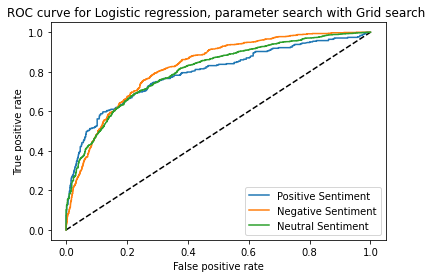

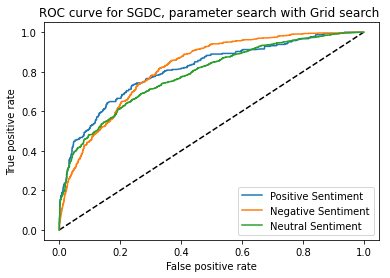

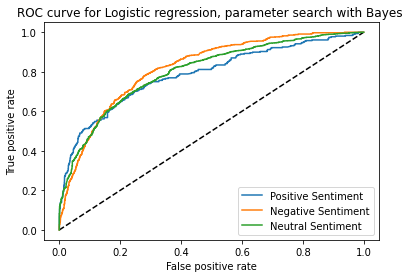

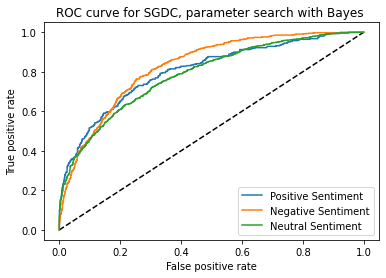

In [ ]:
plt.figure(1)
build_roc_curve(probabilities_logreg_grid,'Logistic regression','Grid search')
plt.figure(2)
plt.subplot=build_roc_curve(probabilities_sgd_grid,'SGDC','Grid search')
plt.figure(3)
plt.subplot=build_roc_curve(probabilities_logreg_bayes,'Logistic regression','Bayes')
plt.figure(4)
plt.subplot=build_roc_curve(probabilities_sgd_bayes,'SGDC','Bayes')
plt.show()

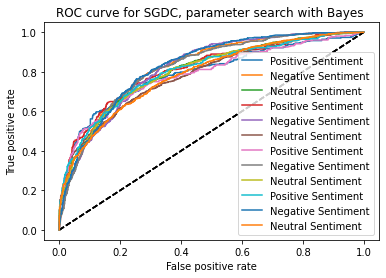

In [ ]:
build_roc_curve(probabilities_logreg_grid,'Logistic regression','Grid search')
plt.subplot=build_roc_curve(probabilities_sgd_grid,'SGDC','Grid search')
plt.subplot=build_roc_curve(probabilities_logreg_bayes,'Logistic regression','Bayes')
plt.subplot=build_roc_curve(probabilities_sgd_bayes,'SGDC','Bayes')
plt.show()

Как видим, ROC-кривые почти полностью накладываются друг на друга, то есть результаты работы разных алгоритмов довольно близки.

Сравним метрики (F1-micro и F1-macro) для всех четырёх случаев

In [ ]:
from tabulate import tabulate

In [ ]:
print(tabulate([
    ['logistic regression','grid_search',count_metrics(labels_for_testing,predicted_labels_logreg_grid)],
    ['SGDC','grid_search',count_metrics(labels_for_testing,predicted_labels_sgd_grid)],
    ['logistic regression','Bayes',count_metrics(labels_for_testing,predicted_labels_logreg_bayes)],
    ['SGDC','Bayes',count_metrics(labels_for_testing,predicted_labels_sgd_bayes)]],
    headers= ['Classifier','Parameter Search',('F1-macro','F1-micro')]))


Classifier           Parameter Search    ('F1-macro', 'F1-micro')
-------------------  ------------------  --------------------------
logistic regression  grid_search         (0.467, 0.499)
SGDC                 grid_search         (0.429, 0.475)
logistic regression  Bayes               (0.48, 0.504)
SGDC                 Bayes               (0.33, 0.445)


Судя по метрикам, **пакетная** реализация оптимизации при обучении в сочетании с подюором параметров с помощью **Байесовской** оптимизации дает лучший результат. Впрочем, метрики, полученные во всех случаях отличаются незначительно (и при этом, к сожалению, все они не высоки).

F1-micro во всех случаях оказалась выше, чем F1-macro. Для того, чтобы понять почему, сформируем classification report для результатов одного из алгоритмов, например, того,для которого эта разница наиболее заметна (SGDClassifier + BayesSearchSV).

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report (labels_for_testing, predicted_labels_sgd_bayes))

              precision    recall  f1-score   support

    negative       0.57      0.47      0.52       767
     neutral       0.76      0.89      0.82      2238
    positive       0.86      0.08      0.14       308

    accuracy                           0.72      3313
   macro avg       0.73      0.48      0.49      3313
weighted avg       0.72      0.72      0.69      3313



Как видим, положительных твитов в 2,5 раза меньше, чем отрицательных. 
Положительные твиты классифицируются хуже (возможно,опять же, из-за ассиметрии классов, на что указывает низкая полнота), поэтому F1 для них ниже.
При микроусреднении это не так заметно, т.к. на него в большей степени влияют отрицательные твиты (потому что их больше), которые классифицируются лучше. При макроусреднении ассиметрия классов уже "не спасает", поэтому эта метрика получается ниже.

Сравним алгоритмы по критерию вычислительного быстродействия 

In [ ]:
print(tabulate([
    ['Grid', time_passed_grid_1,time_passed_grid_2],
    ['Bayes',time_passed_bayes_1,time_passed_bayes_2]],
    headers= ['Search','','']))

Search
--------  --------  --------
Grid       7.18517   1.84492
Bayes     40.727    32.7667


Байесовская оптимизации выполняется в несколько раз дольше, но, как мы убедились ранее, даёт лучший результат

In [ ]:
print(tabulate([
    ['LogRegression', time_passed_logreg_1,time_passed_logreg_2],
    ['SGDC',time_passed_sgd_1,time_passed_sgd_2]],
    headers= ['Classifier','','']))

Classifier
-------------  ---------  ---------
LogRegression  0.251502   0.198388
SGDC           0.0999379  0.0711842


Стохастическая реализация обучения работает быстрее.

[Jupyter-ноутбук с классификацией отзывов о телекомах. ](https://colab.research.google.com/drive/1ash9Q6QVcqE5iBRYC9KhYVwHmVhikijY#scrollTo=f1oya0ocwLV0)

**Краткое содержание:** метрики немного выше, чем для банков: F1-macro от 0,45 и F1-micro от 0,6. Отрицательные твиты классифицируются лучше, чем здесь, а положительные - хуже. При этом дисбаланс классов выражен ещё сильнее (отрицательных твитов в 5 раз больше, чем положительных). На мой взглад, макроусреднение в таком случаее более показательно, а по макроусреднению лучшим оказалась та же комбинация методов (LogisticRegression + BayesSearchCV).